In [2]:
import numpy as np
import pandas as pd
import os
# import keyboard
import matplotlib.pyplot as plt

from utils import * #ecef_to_llh, llh_to_ecef
from read_user import User
from read_obs import read_obs_data
from read_base import parse_rinex_observation_data


# dir_path = os.path.dirname(os.path.realpath(__file__))
dir_path = os.getcwd()
# data = 'Munich10Min100m' # 'Circle_radius 100', Eipcycloid, data
data_path = 'Ref' #'for_real/Case4_Suburban_10Hz' #'Ref'  for_real/Case1_Suburban, Case1_Urban
folder_path = os.path.join(dir_path, data_path)

''' Get User Position, IMU, ODM'''
user = User()
user.read_user_data(os.path.join(folder_path, 'UserPos_100.log'))
# user.read_imu_data(os.path.join(folder_path, 'Log_Sensor_True_IMU.log'))
# user.read_odo_data(os.path.join(folder_path, 'Log_Sensor_True_ODO.log')) #Log_Sensor_True_ODM

origin = user.pos_llh[0,:]

'''Get GNSS'''


# NOTE: simulator old version has .24o file, new version has .rnx file 
# rinex_file_path = os.path.join(folder_path + "\Rcv", find_file(folder_path + "\Rcv", 'V', '.rnx')[0]) # 's101325q.24o'
rinex_file_path = os.path.join(folder_path, find_file(folder_path, 'V', '.rnx')[0])
sp3_file_path = [os.path.join(folder_path, find_file(folder_path, 'GPS', '.SP3')[0]), os.path.join(folder_path, find_file(folder_path, 'GAL', '.SP3')[0])]
# sp3_file_path = [os.path.join(folder_path, find_file(folder_path, 'GAL', '.SP3')[0])]
multipath_file_path = os.path.join(folder_path, 'Multipath_U100.log')
rec_pow_file_path = [os.path.join(folder_path, 'ReceivedPower_101_GPS_L1.log'), os.path.join(folder_path, 'ReceivedPower_101_GALILEO_E1.log')]

obs_dir, obs_mp, obs_all, obs_real = read_obs_data(rinex_file_path, sp3_file_path, multipath_file_path = multipath_file_path, rec_pow_file_path = rec_pow_file_path)

'''Static base station'''
base_rinex_file_path = os.path.join(folder_path + "\Ref", find_file(folder_path + "\Ref", 'V', '.rnx')[0]) # 's101325q.24o'
base_position, base_ecef = [10.004068, -9.993423, 0], False # Ref
# base_position, base_ecef = [4174011.359, 852901.439, 4730709.026], True # 20250730 Urban_Output
# base_position, base_ecef = [48.07786620204981, 11.630701090092355, 551.5], False # for_real/Case1_Urban
base_obs = parse_rinex_observation_data(base_rinex_file_path)

In [3]:
# Collect all unique IDs
unique_ids = {obs.id for obs_list in obs_dir.values() for obs in obs_list}
print(sorted(unique_ids))



print('Total obs_dir: ', sum(len(v) for v in obs_dir.values()), 
        ', Total obs_mp: ', sum(len(v) for v in obs_mp.values()), 
        ', Total obs_all: ', sum(len(v) for v in obs_all.values()), 
        ', Total obs_real: ', sum(len(v) for v in obs_real.values()))

# print('Total dir in real obs: ', sum(len(v) for v in obs_real.multipath()))
total_true = sum(v.multipath for v_list in obs_real.values() for v in v_list)
total_false = sum(not v.multipath for v_list in obs_real.values() for v in v_list)
print(f"Real observations with multipath = True: {total_true}") # 1
print(f"Real observations with multipath = False: {total_false}") # 0


# print(len([obs.id for obs_list in obs_real.values() for obs in obs_list if obs.id.startswith('PL01')]))
# print(len([obs.id for obs_list in obs_real.values() for obs in obs_list if obs.id.startswith('G03')]))


for uid in sorted(unique_ids):
    # Get all obs with this id
    obs_list = [obs for obs_list in obs_real.values() for obs in obs_list if obs.id == uid]

    total = len(obs_list)
    mp_true = sum(obs.multipath for obs in obs_list)
    mp_false = total - mp_true

    print(f"{uid}: total={total}, multipath=True={mp_true}, multipath=False={mp_false}, mp percentage={round(mp_true/(total),3)}")

['G01', 'G02', 'G09', 'G10', 'G13', 'G14', 'G18', 'G19', 'G22', 'G26', 'G27', 'PL01', 'PL02', 'PL03', 'PL04', 'PL05', 'PL06', 'PL07', 'PL08', 'PL09', 'PL10', 'PL11', 'PL12']
Total obs_dir:  56115 , Total obs_mp:  128415 , Total obs_all:  184530 , Total obs_real:  56115
Real observations with multipath = True: 27862
Real observations with multipath = False: 28253
G01: total=3001, multipath=True=2539, multipath=False=462, mp percentage=0.846
G02: total=3001, multipath=True=2226, multipath=False=775, mp percentage=0.742
G09: total=3001, multipath=True=2423, multipath=False=578, mp percentage=0.807
G10: total=3001, multipath=True=2542, multipath=False=459, mp percentage=0.847
G13: total=1339, multipath=True=1094, multipath=False=245, mp percentage=0.817
G14: total=3001, multipath=True=2593, multipath=False=408, mp percentage=0.864
G18: total=3001, multipath=True=2432, multipath=False=569, mp percentage=0.81
G19: total=3001, multipath=True=2596, multipath=False=405, mp percentage=0.865
G22:

In [4]:
USE_ADJUST_LOS  = True        # False = keep original outputs; True = apply adjust_los
TARGET_GNSS_LOS = 80 #None        # target LOS% for GNSS; set None to leave unchanged
TARGET_PL_LOS   = None #60.0        # target LOS% for PL;   set None to leave unchanged
from adjust_los import adjust_los_percentage

#  Added: build adjusted copy without overwriting obs_real
obs_real_original = obs_real
obs_real_adjusted = None
if USE_ADJUST_LOS:
    obs_percent, rep = adjust_los_percentage(
        obs_dir=obs_dir,
        obs_mp=obs_mp,
        obs_real=obs_real_original,
        GNSS_LOS_percentage=TARGET_GNSS_LOS,
        PL_LOS_percentage=TARGET_PL_LOS,
        # Omit 'config' to use defaults defined in adjust_los.py
    )
    obs_real_adjusted = obs_percent

    # Optional: brief report to verify before/after ratios (does not affect original flow)
    def _fmt(x): return "None" if x is None else f"{x:.1f}"
    print("[LOS rebalance] GNSS:", _fmt(rep["GNSS"]["before"]["ratio_pct"]), "->",
          _fmt(rep["GNSS"]["after"]["ratio_pct"]), "(target:", _fmt(rep["GNSS"]["target_ratio_pct"]), ")")
    print("[LOS rebalance] PL  :", _fmt(rep["PL"]["before"]["ratio_pct"]), "->",
          _fmt(rep["PL"]["after"]["ratio_pct"]), "(target:", _fmt(rep["PL"]["target_ratio_pct"]), ")")

[LOS rebalance] GNSS: 19.5 -> 80.0 (target: 80.0 )
[LOS rebalance] PL  : 89.4 -> 89.4 (target: None )


In [ ]:
from mp_zero_check import apply_mp_policy
from avarage_replacement import apply_avg_policy

#       mode = "keep"       → keep strongest multipath
#       mode = "use_dir"    → use direct-path Obs when |delay| <= ZERO_TOL
#       mode = "use_second" → use second-strongest multipath when |delay| <= ZERO_TOL
POLICY_MODE = "use_dir"     # "use_second" | "use_dir" | "keep" | "average"
ZERO_TOL    = 1e-6
SECOND_NONZERO_ONLY = True # skip the 2nd path if its delay is still 0
PRINT_SAMPLES       = 8

print(f"[policy] mode={POLICY_MODE}, ZERO_TOL={ZERO_TOL}, second_nonzero_only={SECOND_NONZERO_ONLY}")
if POLICY_MODE == "average":
    obs_real_ext = apply_avg_policy(
        obs_dir,
        mp_path=None,
        zero_tol=ZERO_TOL,
        print_samples=PRINT_SAMPLES,
    )
else:
    # "use_second" | "use_dir" | "keep" -> mp_zero_check
    obs_real_ext = apply_mp_policy(
        obs_dir,
        mp_path=None,
        mode=POLICY_MODE,
        zero_tol=ZERO_TOL,
        second_nonzero_only=SECOND_NONZERO_ONLY,
    )

[policy] mode=use_dir, ZERO_TOL=1e-06, second_nonzero_only=True
[MP-only path_delay] checked=27862, zero=12860, nonzero=15002, zero_ratio=0.461561, tol=1e-06 m
[policy(applied here)] keep=15004, use_dir=37327, use_second=0, fallback=0

[RESULT] obs_real_ext built: epochs=3001, total=52331, mp_obs=15004

[Samples: before(best) -> after(chosen)]
  t=1406367000.100 PL01: best(sid=1000125, pd=0.000000, loss=0.541) -> DIR (use_dir)
  t=1406367000.100 PL02: best(sid=1000125, pd=0.000000, loss=-0.259) -> DIR (use_dir)
  t=1406367000.100 PL03: best(sid=1000125, pd=0.000000, loss=-1.210) -> DIR (use_dir)
  t=1406367000.100 PL05: best(sid=1000124, pd=0.000000, loss=-0.414) -> DIR (use_dir)
  t=1406367000.100 PL06: best(sid=1000131, pd=0.000000, loss=1.533) -> DIR (use_dir)
  t=1406367000.100 PL07: best(sid=1000114, pd=0.000000, loss=3.627) -> DIR (use_dir)
  t=1406367000.100 PL08: best(sid=1000125, pd=0.000000, loss=-0.751) -> DIR (use_dir)
  t=1406367000.100 PL09: best(sid=1000140, pd=0.000000,

In [ ]:
obs_dyn_pl = {}
obs_sta_pl = {}

for t, obs_set in obs_real_adjusted.items():

    # --- Dynamic PL: velocity exists and non-zero ---
    dyn_set = {
        obs for obs in obs_set
        if (
            'P' in obs.id
            and obs.satellite_vel is not None
            and np.linalg.norm(obs.satellite_vel) != 0
        )
    }

    # --- Static PL: velocity missing or zero ---
    sta_set = {
        obs for obs in obs_set
        if (
            'P' in obs.id
            and (
                obs.satellite_vel is None
                or np.linalg.norm(obs.satellite_vel) == 0
            )
        )
    }

    if dyn_set:
        obs_dyn_pl[t] = dyn_set
    if sta_set:
        obs_sta_pl[t] = sta_set

print(f"Dynamic PL count: {sum(len(v) for v in obs_dyn_pl.values())}")
print(f"Static PL count: {sum(len(v) for v in obs_sta_pl.values())}")


Dynamic PL count: 20937
Static PL count: 3829


In [ ]:
# CASES = {
#         1: [obs_dir, False, False, False],
#         #  2: [obs_all, False, False, False],
#         #  3: [obs_real, False, False, False],
#         4: [obs_real, False, False, True],
#         5: [obs_dir, False, False, True],
#         6: [obs_real_adjusted, False, False, True],
#         7: [obs_real_adjusted, False, False, True],
#         #  5: [obs_real, False, True, True],
#         #  6: [obs_real, True, False, True],
#         } 

CASES = { # used_data, exclude_PL, exclude_GPS, single_diff_corrected, ele_mask
        # 1: [obs_dir, False, False, True, {'G': 10, 'PL': 25}], # GNSS+PL
        11: [obs_real_adjusted, False, False, True, {'G': 10, 'PL': 25}], # GNSS+PL
        12: [obs_real_adjusted, False, True, True, {'G': 10, 'PL': 25}], # PL only
        13: [obs_real_adjusted, True, False, True, {'G': 10, 'PL': 25}], # GNSS only

        22: [obs_dyn_pl, False, True, True, {'G': 10, 'PL': 25}], # PL only
        # 23: [obs_sta_pl, False, True, True, {'G': 10, 'PL': 25}], # PL only
        # 14: [obs_real_adjusted, True, False, True, {'G': 35, 'PL': 25}], # GNSS only, ele>35
        # 15: [obs_real_adjusted, False, False, True, {'G': 35, 'PL': 25}], 
        
        }

data, estimated_ecef, estimated_cb, estimated_llh, estimated_enu, overlapped_time, idx1, idx2 = get_cases(CASES, user, base_obs, base_position, base_ecef, origin)


%matplotlib qt
user_enu = llh_to_enu(user.pos_llh, origin)
plot_trajectory({'user': user_enu, **{i: llh_to_enu(ecef_to_llh(est_ecef), origin) for i, est_ecef in estimated_ecef.items()}}, 'Title', 'enu', twoD=True)
plt.show()




# print the 2D error
for i in CASES.keys():
    print('CASES: ', i)
    error = np.linalg.norm(estimated_enu[i][idx2[i], :2]-user_enu[idx1[i], :2], axis=1)
    # print("{}: {:.2f}".format("2D error mean", np.mean(error)))
    print(f"2D error: Mean: {np.mean(error):.2f}, Max: {np.max(error):.2f}, Min: {np.min(error):.2f}")




Case 11: Insufficient satellite count: 0 times.
Case 12: Insufficient satellite count: 0 times.
Case 13: Insufficient satellite count: 0 times.
Case 22: Insufficient satellite count: 0 times.
CASES:  11
2D error: Mean: 0.51, Max: 11.14, Min: 0.02
CASES:  12
2D error: Mean: 1.21, Max: 199.02, Min: 0.45
CASES:  13
2D error: Mean: 0.43, Max: 6.13, Min: 0.00
CASES:  22
2D error: Mean: 1.20, Max: 199.02, Min: 0.45


CASES:  11
2D error: Mean: 0.51, Max: 11.14, Min: 0.02
CASES:  12
2D error: Mean: 1.21, Max: 199.02, Min: 0.45
CASES:  13
2D error: Mean: 0.43, Max: 6.13, Min: 0.00
CASES:  22
2D error: Mean: 1.20, Max: 199.02, Min: 0.45


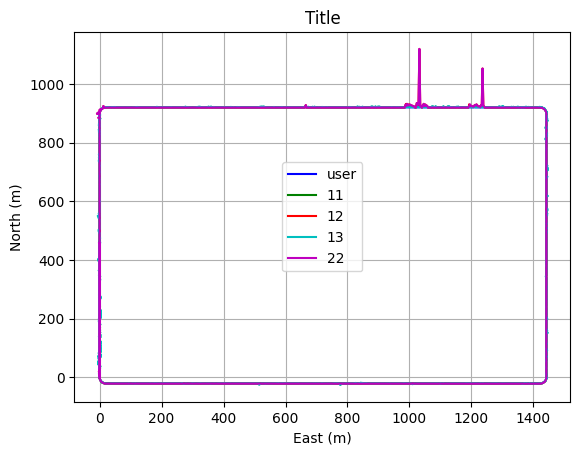

In [ ]:
plot_data = {'user': user_enu}
for i, est_ecef in estimated_ecef.items():
    if est_ecef is None or len(est_ecef) == 0:
        print(f"Skipping Case {i}: empty trajectory")
        continue
    plot_data[i] = llh_to_enu(ecef_to_llh(est_ecef), origin)
    print('CASES: ', i)
    error = np.linalg.norm(estimated_enu[i][idx2[i], :2]-user_enu[idx1[i], :2], axis=1)
    # print("{}: {:.2f}".format("2D error mean", np.mean(error)))
    print(f"2D error: Mean: {np.mean(error):.2f}, Max: {np.max(error):.2f}, Min: {np.min(error):.2f}")

plot_trajectory(plot_data, 'Title', 'enu', twoD=True)


# for i in CASES.keys():


In [ ]:
print_cases_results(CASES, data, estimated_enu, user_enu, idx1, idx2)

stats = analyze_elevation_stats(data, 11)



CASES: 11
Total size of data: 2991  Time duration: 299.0
2D error: Mean=0.51, Max=11.14, Min=0.02, RMSE=0.84
3D error: Mean=0.71, Max=11.79, Min=0.03, RMSE=1.22
Count >10 m: 1 , >5 m: 24 , >3 m: 139
After removing 3D error >10 m (1 samples removed):
  2D error (filtered): Mean=0.51, Max=9.26
  3D error (filtered): Mean=0.70, Max=9.38

CASES: 12
Total size of data: 2991  Time duration: 299.0
2D error: Mean=1.21, Max=199.02, Min=0.45, RMSE=4.57
3D error: Mean=1.30, Max=221.39, Min=0.71, RMSE=5.22
Count >10 m: 28 , >5 m: 47 , >3 m: 55
After removing 3D error >10 m (28 samples removed):
  2D error (filtered): Mean=1.03, Max=6.53
  3D error (filtered): Mean=1.06, Max=9.88

CASES: 13
Total size of data: 2991  Time duration: 299.0
2D error: Mean=0.43, Max=6.13, Min=0.00, RMSE=0.94
3D error: Mean=0.62, Max=9.48, Min=0.00, RMSE=1.40
Count >10 m: 0 , >5 m: 71 , >3 m: 181
After removing 3D error >10 m (0 samples removed):
  2D error (filtered): Mean=0.43, Max=6.13
  3D error (filtered): Mean=0.6

In [ ]:
print(len([obs.id for obs_list in data[4].values() for obs in obs_list if obs.id.startswith('PL01')]))
print(len([obs.id for obs_list in data[4].values() for obs in obs_list if obs.id.startswith('G03')]))

KeyError: 4

In [ ]:
%matplotlib qt
ind_start, ind_end = 520, 1000
skip_by = 1
user_freq_diff = 10 # user frequency difference
plot_trajectory({'user': user_enu[ind_start*user_freq_diff:ind_end*user_freq_diff:skip_by], **{i: llh_to_enu(ecef_to_llh(est_ecef), origin)[ind_start:ind_end:skip_by] for i, est_ecef in estimated_ecef.items()}}, 'plot_title', 'enu', twoD=True, scatter=True)
plt.xlim(-5, 55)  
plt.ylim(-30, 30) 
plt.show()

# Save to CSV

In [ ]:
# '''Save results to CSV for learning'''
# file_path = os.path.join(dir_path, 'for_real/Case4_Suburban_10Hz.csv')
# # Get Residual and Pseudorange Corrected - Clock Bias
# Case_for_learning = 4
# Case_ecef = dict(zip(data[Case_for_learning].keys(), estimated_ecef[Case_for_learning])) 
# Case_cb = dict(zip(data[Case_for_learning].keys(), estimated_cb[Case_for_learning]))
# Case_idx1 = dict(zip(data[Case_for_learning].keys(), idx1[Case_for_learning]))

# all_obs_data = []
# for key, obs_list in data[Case_for_learning].items():
#     for obs in obs_list:
#         obs.calculate_azimuth_elevation(user.pos_ecef[Case_idx1[key]])
#         obs.calculate_pseudorange_residual(Case_ecef[key], Case_cb[key], obs.pseudorange_nav)

#         all_obs_data.append({
#             'gps_time': key,
#             'satellite_id': obs.id,
#             'sv_id': obs.sv_id,
#             'pseudorange': obs.pseudorange,
#             'doppler_shift': obs.doppler_shift,
#             'cn0': obs.CN0,
#             'rec_pow': obs.rec_pow,
#             'azimuth': obs.azimuth,
#             'elevation': obs.elevation,
#             'pseudorange_residual': obs.pseudorange_residual,
#             'pseudorange_corrected_cb': obs.pseudorange_nav - Case_cb[key],
#             'multipath': obs.multipath,
#         })

# # Convert the list of dictionaries to a DataFrame and save it as a CSV file
# pd.DataFrame(all_obs_data).to_csv(file_path, index=False)
# print(f"Obseration data has been saved to {file_path}")